In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.spectral_tools import calc_ispec, coord, spectrum
from pyqg_generative.tools.computational_tools import PDF_histogram
from pyqg_generative.tools.comparison_tools import dataset_statistics, coarsegrain_reference_dataset, dataset_smart_read
from pyqg_generative.tools.simulate import run_simulation
%load_ext autoreload
%autoreload 3

import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

import warnings
warnings.filterwarnings("ignore")

# DCGAN discriminator

In [23]:
class DCGAN(nn.Module):
    def __init__(self, in_channels=1, ndf=64, nx=64):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, int(nx/64*4), 1, 0, bias=False)
        
    def forward(self, x):
        print(x.shape)
        
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]:
            x = conv(x)
            print(x.shape)
        return x

In [29]:
nx = 64
D = DCGAN(nx=nx)
print(D)
D(torch.randn(1,1,nx,nx))

DCGAN(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
torch.Size([1, 1, 64, 64])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 1, 1, 1])


tensor([[[[0.0465]]]], grad_fn=<ConvolutionBackward0>)

In [30]:
nx = 48
D = DCGAN(nx=nx)
print(D)
D(torch.randn(1,1,nx,nx))

DCGAN(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
)
torch.Size([1, 1, 48, 48])
torch.Size([1, 64, 24, 24])
torch.Size([1, 128, 12, 12])
torch.Size([1, 256, 6, 6])
torch.Size([1, 512, 3, 3])
torch.Size([1, 1, 1, 1])


tensor([[[[0.0373]]]], grad_fn=<ConvolutionBackward0>)

In [31]:
nx = 32
D = DCGAN(nx=nx)
print(D)
D(torch.randn(1,1,nx,nx))

DCGAN(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
)
torch.Size([1, 1, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 128, 8, 8])
torch.Size([1, 256, 4, 4])
torch.Size([1, 512, 2, 2])
torch.Size([1, 1, 1, 1])


tensor([[[[0.0013]]]], grad_fn=<ConvolutionBackward0>)

In [32]:
nx = 24
D = DCGAN(nx=nx)
print(D)
D(torch.randn(1,1,nx,nx))

DCGAN(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
torch.Size([1, 1, 24, 24])
torch.Size([1, 64, 12, 12])
torch.Size([1, 128, 6, 6])
torch.Size([1, 256, 3, 3])
torch.Size([1, 512, 1, 1])
torch.Size([1, 1, 1, 1])


tensor([[[[-0.0047]]]], grad_fn=<ConvolutionBackward0>)

In [33]:
nx = 16
D = DCGAN(nx=nx)
print(D)
D(torch.randn(1,1,nx,nx))

DCGAN(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
torch.Size([1, 1, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 128, 4, 4])
torch.Size([1, 256, 2, 2])
torch.Size([1, 512, 1, 1])
torch.Size([1, 1, 1, 1])


tensor([[[[0.0251]]]], grad_fn=<ConvolutionBackward0>)

In [40]:
# nx = 12
# D = DCGAN(nx=nx)
# print(D)
# D(torch.randn(1,1,nx,nx))

# Coarsegrain DNS data

In [5]:
dns_jet = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc', combine='nested', concat_dim='run').load()
dns_eddy = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', combine='nested', concat_dim='run').load()

In [6]:
for res in [16, 24, 32]:
    print(res)
    coarsegrain_reference_dataset(dns_jet, res, 'Operator5').to_netcdf(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator5-dealias-{res}.nc')
    print(res)
    coarsegrain_reference_dataset(dns_eddy, res, 'Operator5').to_netcdf(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator5-dealias-{res}.nc')

16
var=q
var=u
var=v
var=psi
16
var=q
var=u
var=v
var=psi
24
var=q
var=u
var=v
var=psi
24
var=q
var=u
var=v
var=psi
32
var=q
var=u
var=v
var=psi
32
var=q
var=u
var=v
var=psi


# Reading DNS/LES data

In [24]:
dns = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', delta=0.25, compute_all=False)

In [25]:
fdns = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator5-48.nc', 
    delta=0.25, compute_all=False)

In [26]:
ols = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator5-dealias-48/OLSModel-0/eddy-constant-0/[0-9].nc', 
    delta=0.25, compute_all=False)

In [27]:
gz = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator5-dealias-48/MeanVarModel-0/eddy-constant-0/[0-9].nc', 
    delta=0.25, compute_all=False)

In [28]:
gan = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator5-dealias-48/CGANRegression-0/eddy-constant-0/[0-9].nc', 
    delta=0.25, compute_all=False)

In [29]:
vae = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator5-dealias-48/CVAERegression-0/eddy-constant-0/[0-9].nc', 
    delta=0.25, compute_all=False)

In [30]:
lores = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/3-2-dealiasing/reference_48/[0-9].nc', 
    delta=0.25, compute_all=False)

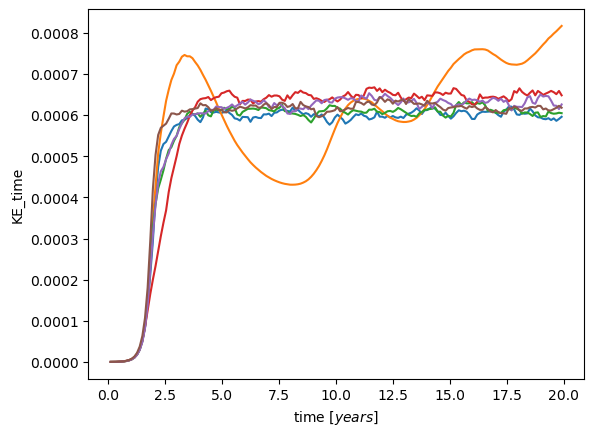

In [40]:
fdns.KE_time.mean('run').plot()
lores.KE_time.mean('run').plot()
ols.KE_time.mean('run').plot()
gz.KE_time.mean('run').plot()
gan.KE_time.mean('run').plot()
vae.KE_time.mean('run').plot()

In [7]:
def plot_online(operator='Operator5-dealias', resolution=48, configuration='eddy', exp='eddy-constant-0', ref='3-2-dealiasing/reference_48', delta=0.25, read_cache=True):
    def read_experiment(model='OLSModel', model_num=0, resolution=64, operator='Operator1', exp=exp, read_cache=read_cache, delta=delta):
        folder = os.path.join('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain', operator+'-'+str(resolution),model+'-'+str(model_num),exp)
        path = os.path.join(folder,'[0-9].nc')

        keyphrase = 'Warning: CFL>1. Computations are stopped.'
        err = os.path.join(folder, '*err*')
        os.system(f'cat {err} | grep "{keyphrase}"')
        
        ds = dataset_smart_read(path, read_cache=read_cache, delta=delta)
        return ds.isel(time=slice(0,None,2))

    def collapse_trials(**kw):
        ds = []
        try:
            for j in range(2):
                ds.append(read_experiment(model_num=j, **kw))
            ds = xr.concat(ds, dim='trial')

            return ds
        except:
            print(f"{kw['model']} at resolution {kw['resolution']} and {kw['operator']} is unstable")
            return None

    mse = collapse_trials(resolution=resolution, operator=operator, model='OLSModel')
    gz = collapse_trials(resolution=resolution, operator=operator, model='MeanVarModel')
    gan = collapse_trials(resolution=resolution, operator=operator, model='CGANRegression')
    vae = collapse_trials(resolution=resolution, operator=operator, model='CVAERegression')
    
    target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{configuration}/reference_256/{operator}-{str(resolution)}.nc', delta=delta, read_cache=read_cache).isel(time=slice(0,None,2))
    try:
        coarse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{configuration}/{ref}/[0-9].nc', delta=delta, read_cache=read_cache).isel(time=slice(0,None,2))
    except:
        pass

    default_rcParams(
        {'lines.linewidth': 2,
         'font.size': 12,
         'axes.labelsize': 12,
         'axes.titlesize': 12,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12,
         'legend.fontsize': 12})
    fig, axs = plt.subplots(3,2,figsize=(8,8))
    plt.subplots_adjust(hspace=0.55)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    lss = ['-', '--', '-.', ':']
    lws = [None, None, None, None]
    alphas = [0.2, 0.2, 0.2, 0.2]
    hatch = [None, None, None, None]
    models = [mse, gz, gan, vae]
    labels=['MSE', 'GZ', 'GAN', 'VAE']

    ax = axs[0][0]
    target.KE_time.mean('run').plot(ax=ax, color='k', ls='-', lw=1)
    try:
        coarse.KE_time.mean('run').plot(ax=ax, color='gray')
    except:
        pass
    for j, m in enumerate(models):
        try:
            m.KE_time.mean('run').median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
            ax.fill_between(m.time, m.KE_time.mean('run').min('trial'), m.KE_time.mean('run').max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
        except:
            pass
    ax.set_ylabel(r'$E, m^2/s^2$')
    ax.set_xlabel('t, $years$')
    ax.set_title('Kinetic energy')
    ax.set_yticks(np.arange(0,9)*1e-4)
    ax.set_ylim([0,8e-4])
    if configuration=='jet' and resolution==64:
        ax.set_ylim([-0.2e-4, 4.0e-4])

    ax = axs[1][0]
    (0.5*target.KEspecr_mean).plot(ax=ax, color='k', ls='-', lw=1)
    try:
        (0.5*coarse.KEspecr_mean).plot(ax=ax, color='gray')
    except:
        pass
    for j, m in enumerate(models):
        try:
            (0.5*m.KEspecr_mean.median('trial')).plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
            ax.fill_between(m.kr, 0.5*m.KEspecr_mean.min('trial'), 0.5*m.KEspecr_mean.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
        except:
            pass
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([5e-2, 2e+1])
    if configuration=='jet':
        ax.set_ylim([5e-3, 2e+1])
    ax.set_ylabel('$E(\kappa), m^3/s^2$')
    ax.set_xlabel(r'wavenumber $\kappa, m^{-1}$')
    ax.set_title('KE spectrum')

    ax = axs[2][0]
    target.Efluxr.plot(ax=ax, color='k', ls='-', lw=1)
    try:
        coarse.Efluxr.plot(ax=ax, color='gray')
    except:
        pass
    for j, m in enumerate(models):
        try:
            m.Efluxr.median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
            ax.fill_between(m.kr, m.Efluxr.min('trial'), m.Efluxr.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
        except:
            pass
    ax.set_xscale('log')
    ax.set_ylim([-1.5e-6, 1.5e-6])
    ax.set_yticks(np.linspace(-1.5e-6,1.5e-6,7))
    if configuration=='jet' and resolution==48:
        ax.set_ylim([-1.5e-6, 1.5e-6])
    if configuration=='jet' and resolution==64:
        ax.set_ylim([-0.8e-6, 0.8e-6])
    ax.set_ylabel(r'$\partial_t \mathcal{E}(\kappa), m^3/s^3$')
    ax.set_xlabel(r'wavenumber $\kappa, m^{-1}$')
    ax.set_title('Energy transfer')

    for col,var in enumerate(['PDF_Ens1', 'PDF_KE1', 'PDF_KE2']):
        ax=axs[col][1]
        target[var].plot(ax=ax, color='k', ls='-', lw=1, label=r'$\overline{\mathrm{hires}}(256^2)$')
        try:
            coarse[var].plot(ax=ax, color='gray', label='lores')
        except:
            pass

        for j, m in enumerate(models):
            try:
                m[var].median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j], label=labels[j])
                xx=[k for k in m[var].median('trial').coords.values()][0]
                ax.fill_between(xx, m[var].min('trial'), m[var].max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
                ax.set_yscale('log')
            except:
                pass

    ax = axs[0][1]
    ax.set_ylabel('PDF density')
    ax.set_xlabel(r'$\frac{1}{2}|\mathrm{curl}(\mathbf{u}_1)|^2, s^{-2}$')
    ax.set_title('Upper enstrophy')

    ax = axs[1][1]
    ax.set_ylabel('PDF density')
    ax.set_xlabel(r'$\frac{1}{2}|\mathbf{u}_1|^2, m^2s^{-2}$')
    ax.set_title('Upper KE')

    ax = axs[2][1]
    ax.set_ylabel('PDF density')
    ax.set_xlabel(r'$\frac{1}{2}|\mathbf{u}_2|^2, m^2s^{-2}$')
    ax.set_title('Lower KE')

    axs[0][1].set_ylim([1e+7, 4e+11])
    axs[0][1].set_yticks([1e+7,1e+8,1e+9,1e+10,1e+11])
    axs[1][1].set_ylim([1e+0, 1e+3])
    if configuration=='jet':
        axs[1][1].set_ylim([1e-1, 1e+3])
    axs[2][1].set_ylim([1e+1, 8e+4])
    if configuration=='jet':
        axs[2][1].set_ylim([1e-1, 8e+4])
    axs[2][1].set_yticks([1e-1,1e0,1e+1,1e+2,1e+3,1e+4])

    axs[2][1].set_xticks([0, 1e-4, 2e-4, 3e-4, 4e-4])

    axs[2][1].legend(bbox_to_anchor=(0,-0.7), ncol=3, loc='center', fontsize=16)

    fig.align_ylabels()
    set_letters(x=-0.2, y=1.1, fontsize=13, letters=['a', 'd', 'b', 'e', 'c', 'f'])

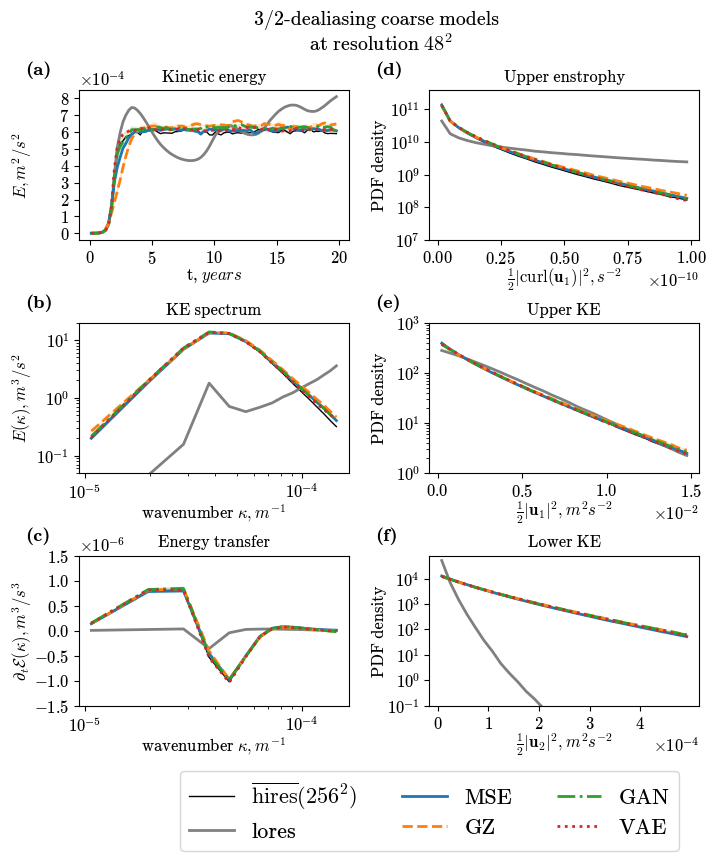

In [4]:
plot_online(read_cache=True)
plt.suptitle('3/2-dealiasing coarse models \n at resolution $48^2$')
#plt.show()
plt.savefig('review_figures/3-2-dealiasing-48.pdf')

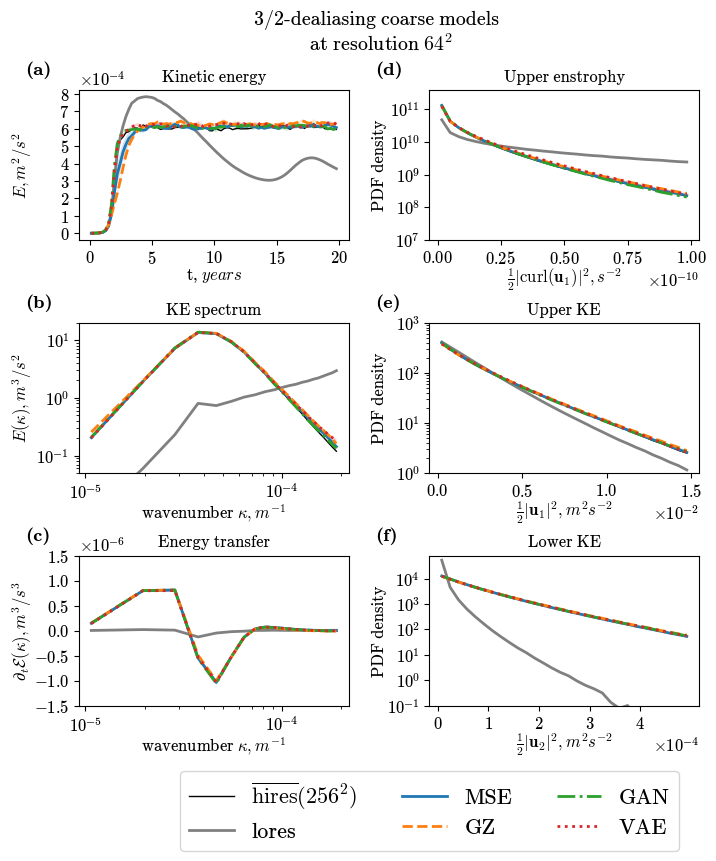

In [5]:
plot_online(resolution=64, ref='3-2-dealiasing/reference_64')
#plt.show()
plt.suptitle('3/2-dealiasing coarse models \n at resolution $64^2$')
plt.savefig('review_figures/3-2-dealiasing-64.pdf')

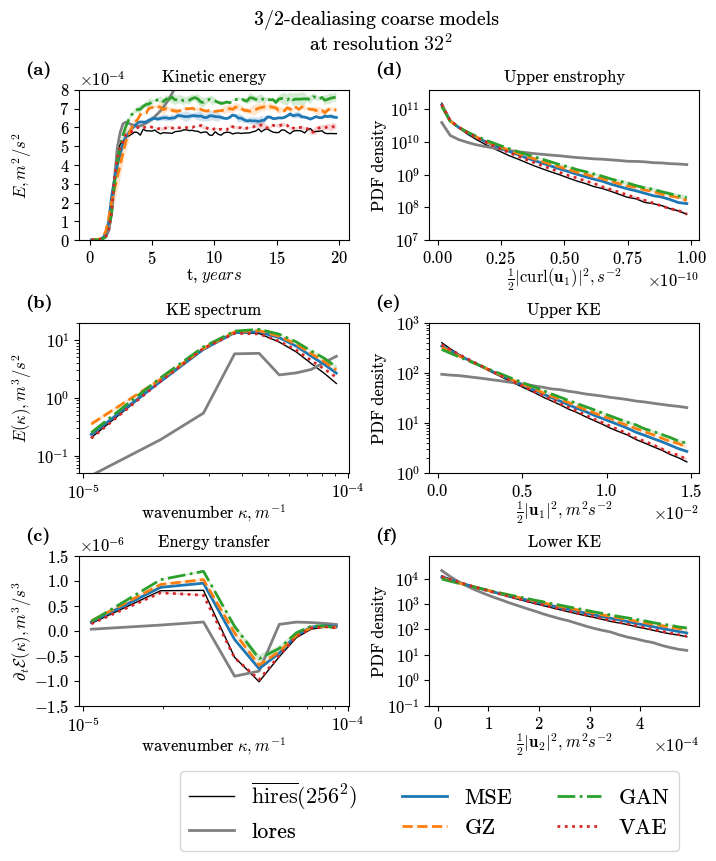

In [8]:
plot_online(resolution=32, ref='3-2-dealiasing/reference_32')
plt.suptitle('3/2-dealiasing coarse models \n at resolution $32^2$')
plt.savefig('review_figures/3-2-dealiasing-32.pdf')

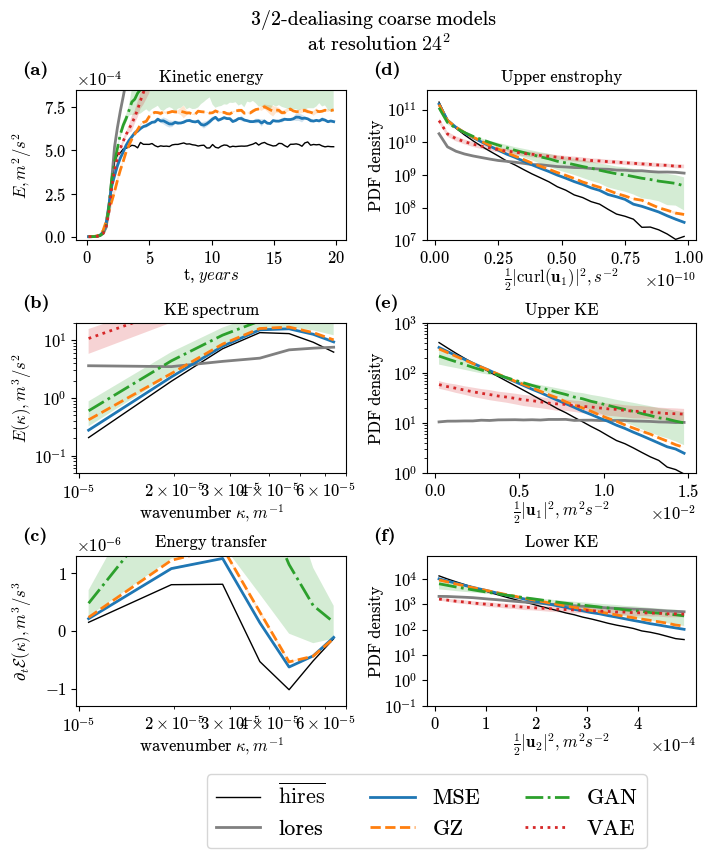

In [13]:
plot_online(resolution=24, ref='3-2-dealiasing/reference_24')
plt.suptitle('3/2-dealiasing coarse models \n at resolution $24^2$')
plt.show()
#plt.savefig('review_figures/3-2-dealiasing-24.pdf')

In [17]:
plot_online(resolution=16, ref='3-2-dealiasing/reference_16')
plt.suptitle('3/2-dealiasing coarse models \n at resolution $16^2$')
#plt.show()
plt.savefig('review_figures/3-2-dealiasing-16.pdf')

INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
CGANRegression at resolution 16 and Operator5-dealias is unstable
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. 

In [139]:
plot_online(exp='jet-constant-0', configuration='jet', delta=0.1)
plt.suptitle('3/2-dealiasing coarse models \n at resolution $48^2$ \n generalization to JET configuration', y=1.03)
#plt.show()
plt.savefig('review_figures/3-2-dealiasing-48-jet.pdf')

INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
CGANRegression at resolution 48 and Operator5-dealias is unstable


In [18]:
plot_online(resolution=32, ref='3-2-dealiasing/reference_32', exp='jet-constant-0', configuration='jet', delta=0.1)
plt.suptitle('3/2-dealiasing coarse models \n at resolution $32^2$ \n generalization to JET configuration', y=1.03)
#plt.show()
plt.savefig('review_figures/3-2-dealiasing-32-jet.pdf')

INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
OLSModel at resolution 32 and Operator5-dealias is unstable
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Comput

In [140]:
plot_online(resolution=64, ref='3-2-dealiasing/reference_64', exp='jet-constant-0', configuration='jet', delta=0.1)
plt.suptitle('3/2-dealiasing coarse models \n at resolution $64^2$ \n generalization to JET configuration', y=1.03)
#plt.show()
plt.savefig('review_figures/3-2-dealiasing-64-jet.pdf')

INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
INFO: Warning: CFL>1. Computations are stopped.
CGANRegression at resolution 64 and Operator5-dealias is unstable


# Reading DNS/LES data

In [11]:
fdns = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator5-dealias-64.nc', 
    delta=0.1)

In [18]:
lores = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/3-2-dealiasing/reference_64/[0-9].nc', 
    delta=0.1)

In [12]:
ols = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator5-dealias-64/OLSModel-0/jet-constant-0/[0-9].nc', 
    delta=0.1)

In [13]:
gz = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator5-dealias-64/MeanVarModel-0/jet-constant-0/[0-9].nc', 
    delta=0.1)

In [14]:
vae = dataset_smart_read(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator5-dealias-64/CVAERegression-0/jet-constant-0/[0-9].nc', 
    delta=0.1)

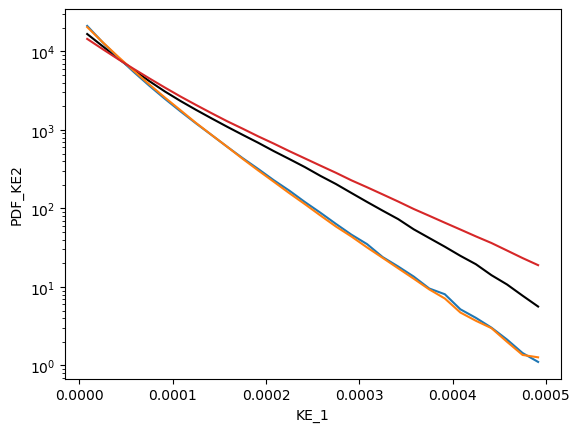

In [31]:
fdns.PDF_KE2.plot(color='k')
#lores.PDF_u1.plot()
ols.PDF_KE2.plot(color='tab:blue')
gz.PDF_KE2.plot(color='tab:orange')
vae.PDF_KE2.plot(color='tab:red')
plt.yscale('log')
plt.show()